In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
from IPython.display import Image
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import Image
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import load_img
import glob
from keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load Data

In [2]:
img_dir = 'images/'
mask_dir = 'masks/'
with open('classes.txt', 'r') as f:
    labels = f.read().split(',')

In [3]:
image_files = glob.glob(img_dir+'*')
mask_files = glob.glob(mask_dir+'*')

In [4]:
images = []
masks = []
target_size = (128,128)
for i, img_file in enumerate(image_files):
    img = load_img(img_file, color_mode='rgb', target_size=target_size)
    images.append(img)
    
    mask = load_img(mask_files[i], color_mode='grayscale', target_size=target_size)
    masks.append(mask)

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Split Data

In [5]:
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.1, shuffle=True, random_state=123)

# Augmentation
The dataset is very small (~200 images), so data augmentation is necessary. Data augmentation refers to addiing "new" images to the dataset that are created by performing various operations on existing training data. For this dataset, I limit those operations to arbitrary rotations and small translations of images. Since our training targets are also images, if an image is rotated or translated, its associated mask must be as well. Imagine if a picture of a car is rotated 90 degrees. We then want the model to predict where the windows, wheels, etc. are after the rotatation, not before the rotation.

In [6]:
def rotate_image(img, mask):
    '''
    Rotates an image and associated mask by a random angle
    '''
    angle = np.random.uniform(-180,180)
    img = img.rotate(angle)
    mask = mask.rotate(angle)
    return img, mask

def translate_image(img, mask):
    '''
    Translates an image and associated mask randomly by up to 10 pixels in any direction
    Coefficients below transform (x, y) --> (ax+by+c, dx+ey+f), thus a=e=1
    '''
    a, b, d, e = 1, 0, 0, 1
    c = np.random.uniform(-10,10)
    f = np.random.uniform(-10,10)
    img = img.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    mask = mask.transform((img.size), Image.AFFINE, (a,b,c,d,e,f))
    return img, mask

def augmentation(images, masks):
    trans_count = 0
    rot_count = 0
    print(len(images))
    augmented_images, augmented_masks = images.copy(), masks.copy()
    for i, img in enumerate(images):
        # Note some *small* probability of these both being true and still no augmentation
        rotate = bool(np.round(np.random.uniform(0,1)))
        translate = bool(np.round(np.random.uniform(0,1)))
        
        mask = masks[i]
        if rotate:
            img, mask = rotate_image(img, mask)
            rot_count += 1
        if translate:
            img, mask = translate_image(img, mask)
            trans_count += 1
        if translate or rotate:
            augmented_images.append(img)
            augmented_masks.append(mask)
    
    print(f'Rotated {rot_count} images')
    print(f'Translated {trans_count} images')
    return augmented_images, augmented_masks

aug_rounds = range(3)
for round in aug_rounds:
    x_train, y_train = augmentation(x_train, y_train)

189
Rotated 107 images
Translated 88 images
332
Rotated 179 images
Translated 170 images
592
Rotated 298 images
Translated 303 images


# Convert Images to Numpy

In [7]:
def data_to_numpy(images, masks):
    images = [np.asarray(img) for img in images]
    masks = [np.asarray(mask) for mask in masks]
    
    return np.asarray(images)/255, np.asarray(masks)

x_train, y_train = data_to_numpy(x_train, y_train)
x_test, y_test = data_to_numpy(x_test, y_test)

# Build Model
The model used is essentially U-Net. There is a downscaling portion of the model and an upscaling portion. The downscaling portions consists of convolutional layers followed by maxpooling layers which half the size of the image in each direction. The upscaling portion does the reverse: transposed convolutions upscale the image and more convolutional layers extract features as the image is upscaled. Once the upscaling is complete, the model is passed through a dense layer. To pass information through the network and preserve gradients, skip connections are used. In the downscaling part of the network, before maxpooling, the feature maps are saved. These are then concatenated with feature map outputs of the appropriate shape during upscaling.

The model output is a probability distribution over the classes for each pixel in the image. The model is evaluated using pixel-wise accuracy, the percentage of pixels that are correctly classified.

In [8]:
def get_model(img_shape, num_classes):
    inputs = keras.Input(shape=img_shape)
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(inputs) 
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(64, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.Conv2D(64, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(128, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.Conv2D(128, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(256, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.Conv2D(256, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(512, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.Conv2D(512, kernel_size =(3), strides=2, activation='relu', padding='same')(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(1024, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1024, kernel_size =(3), activation='relu', padding='same')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(512, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) 
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)
    
    # Second upconv layer
    x = layers.Conv2DTranspose(256, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(128, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(64, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(num_classes, kernel_size=(1), activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [9]:
def get_model_w_pooling(img_shape, num_classes):
    inputs = keras.Input(shape=img_shape)
    
    # Downsampler
    # First convolutional block
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(inputs) 
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(64, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_1 = x # first skip connection to be concatenated with last transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Second convolutional block
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(128, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_2 = x # second skip connection to be concatenated with third transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(256, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_3 = x # second skip connection to be concatenated with second transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)     
    x = layers.Conv2D(512, kernel_size =(3), activation='relu', padding='same')(x)
    skip_con_4 = x # second skip connection to be concatenated with first transpose convolution
    x = layers.MaxPool2D(pool_size=(2), strides=(2))(x)
    
    # Fifth convolutional block
    x = layers.Conv2D(1024, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1024, kernel_size =(3), activation='relu', padding='same')(x)

    # Upsampler
    # First upconv layer
    x = layers.Conv2DTranspose(512, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_4]) 
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, kernel_size=(3), activation='relu', padding='same')(x)
    
    # Second upconv layer
    x = layers.Conv2DTranspose(256, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_3])
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=(3), activation='relu', padding='same')(x)
    
    # Third upconv layer
    x = layers.Conv2DTranspose(128, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_2])
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3), activation='relu', padding='same')(x)

    # Fourth upconv layer
    x = layers.Conv2DTranspose(64, kernel_size=(2), strides=(2))(x)
    x = layers.Concatenate(axis=-1)([x, skip_con_1])
    x = layers.Conv2D(64, kernel_size=(3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(num_classes, kernel_size=(1), activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(x_train[0].shape, len(labels))
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [15]:
es = EarlyStopping(min_delta=0.001, patience=10,restore_best_weights=True)
history = model.fit(x_train, y_train, validation_split=0.1, epochs=100, callbacks=[es])

Epoch 1/3
30/30 [==============================] - 7s 249ms/step - loss: 0.8070 - accuracy: 0.6742 - val_loss: 0.7163 - val_accuracy: 0.7041
Epoch 2/3
30/30 [==============================] - 37s 1s/step - loss: 0.7812 - accuracy: 0.6817 - val_loss: 0.7033 - val_accuracy: 0.6911
Epoch 3/3
30/30 [==============================] - 45s 2s/step - loss: 0.7075 - accuracy: 0.7052 - val_loss: 0.6467 - val_accuracy: 0.7383


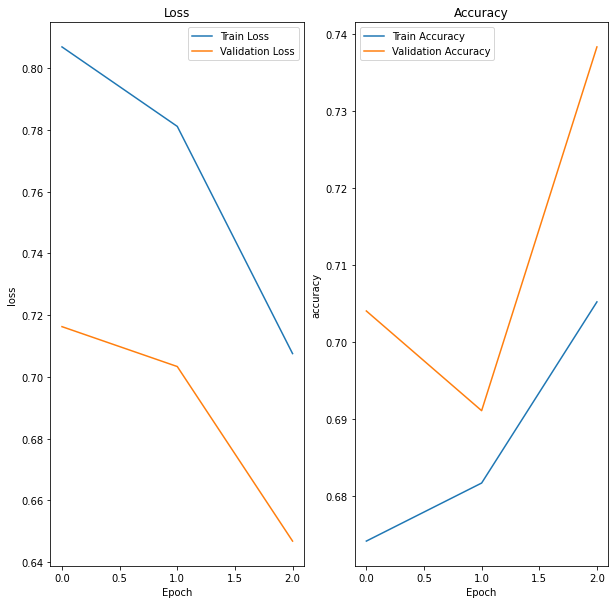

In [20]:
loss_metrics = history.history
epochs = range(len(loss_metrics['loss']))

fig, axes = plt.subplots(1,2, figsize=(10,10))

# Loss
sns.lineplot(loss_metrics, x=epochs, y='loss', label='Train Loss', ax=axes[0])
sns.lineplot(loss_metrics, x=epochs, y='val_loss', label='Validation Loss', ax=axes[0])
axes[0].set_xlabel('Epoch')
axes[0].set_title('Loss')

# Accuracy
sns.lineplot(loss_metrics, x=epochs, y='accuracy', label='Train Accuracy', ax=axes[1])
sns.lineplot(loss_metrics, x=epochs, y='val_accuracy', label='Validation Accuracy', ax=axes[1])
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

plt.show()

In [12]:
y_pred = model.predict(x_test)
y_pred = K.argmax(y_pred, axis=-1)

1/1 [==============================] - 2s 2s/step


In [45]:
fig.axes[0].imshow(x_test[0])
plt.show()

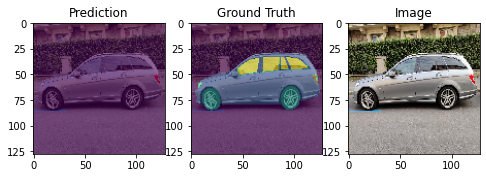

In [56]:
test_idx=np.random.randint(0, len(x_test))
fig, axes = plt.subplots(1,3, figsize=(8,8))

# Predictions
axes[0].imshow(x_test[test_idx])
axes[0].imshow(y_pred[test_idx], alpha=0.6)
axes[0].set_title('Prediction')

# Ground Truth
axes[1].imshow(x_test[test_idx])
axes[1].imshow(y_test[test_idx], alpha=0.6)
axes[1].set_title('Ground Truth')

## Raw image
axes[2].imshow(x_test[test_idx])
axes[2].set_title('Image')

plt.show()

In [14]:
iou = IoU(num_classes=len(labels), target_class_ids=range(len(labels)))

NameError: name 'IoU' is not defined